<a href="https://colab.research.google.com/github/npadhye/multiscale_entropy/blob/main/msentropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install EntropyHub and Upload Data

In [ ]:
!pip install EntropyHub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 5.6 MB/s 
     |████████████████████████████████| 64 kB 1.2 MB/s 
     |████████████████████████████████| 76 kB 3.0 MB/s 
     |████████████████████████████████| 52 kB 794 kB/s 


Import two files:
* Data in `tabd_all.csv`
* On/off times and correlation times in `onoff_corrtime_dim_summary.csv`

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving onoff_corrtime_dim_summary.csv to onoff_corrtime_dim_summary.csv
User uploaded file "onoff_corrtime_dim_summary.csv" with length 3188 bytes


In [ ]:
import pandas as pd
#tsdat = pd.read_csv("tabd_all.csv", index_col="tstamp", parse_dates=True, squeeze=True)
tsdat = pd.read_csv("tabd_all.csv", parse_dates=True, squeeze=True)
onoffdat = pd.read_csv("onoff_corrtime_dim_summary.csv")

In [ ]:
tsdat.head()

,subject_id,tstamp,unit,temperature
0,1,2019-06-20 11:51:00,C,27.064
1,1,2019-06-20 11:52:00,C,26.689
2,1,2019-06-20 11:53:00,C,26.002
3,1,2019-06-20 11:54:00,C,26.314
4,1,2019-06-20 11:55:00,C,28.752


In [ ]:
tsdat.dtypes

subject_id       int64
tstamp          object
unit            object
temperature    float64
dtype: object

In [ ]:
onoffdat.head()

,subject_id,i_on,i_off,n,series,tau_acf,tau_ami,emb_dim,cor_dim,se_cd,prinj,prinj_stg,prinj_loc,prinj_visit
0,1,226,3039,2814,y,188,21,5,2.767961,0.257116,1,3.0,8.0,0
1,1,226,3039,2814,y_diff,11,5,10,2.248087,0.166137,1,3.0,8.0,0
2,2,1220,4048,2829,y,198,97,4,1.799780,0.256632,0,NaN,NaN,3
3,2,1220,4048,2829,y_diff,75,24,9,2.257830,0.356203,0,NaN,NaN,3
4,4,1149,3975,2827,y,185,8,7,1.880096,0.107123,1,4.0,9.0,0


In [ ]:
onoffdat.dtypes

subject_id       int64
i_on             int64
i_off            int64
n                int64
series          object
tau_acf          int64
tau_ami          int64
emb_dim          int64
cor_dim        float64
se_cd          float64
prinj            int64
prinj_stg      float64
prinj_loc      float64
prinj_visit      int64
dtype: object

In [ ]:
# calculate mean and median tau values using pandas
print('Mean and Median values of tau \n')
print('Means:')
print(onoffdat[['tau_ami', 'tau_acf']].mean(), '\n')
print('Medians:')
print(onoffdat[['tau_ami', 'tau_acf']].median(), '\n')

# pandas groupby
print('Repeat with grouping by pressure injury \n')
print('Means:')
print(onoffdat[['prinj', 'tau_ami', 'tau_acf']].groupby('prinj').mean(), '\n')
print('Medians:')
print(onoffdat[['prinj', 'tau_ami', 'tau_acf']].groupby('prinj').median(), '\n')

Mean and Median values of tau 

Means:
tau_ami    14.019231
tau_acf    69.423077
dtype: float64 

Medians:
tau_ami     8.5
tau_acf    41.5
dtype: float64 

Repeat with grouping by pressure injury 

Means:
         tau_ami    tau_acf
prinj                      
0      15.100000  69.033333
1      12.545455  69.954545 

Medians:
       tau_ami  tau_acf
prinj                  
0          8.5     41.5
1          8.5     45.0 



# Subjectwise SampEn, MSEn, rMSEn calculations

One subject at a time, i.e. not looped over all subjects. Each subject's data is plotted, entropies calculated, and visualized before saving the results to a file.

Analysis of differenced series can also be found here.

## Select Subject and Section for Analysis

Starting with subj 12, on/off times for the iButton are read from a file with
on/off times, correlation times, embedding dimension, etc.

Notes:
1. Subject 18 has a short series length of 1442

In [ ]:
# select subject
select_subj = 1
subj_i = tsdat['subject_id'] == select_subj
tsdat_i = tsdat[subj_i]
tsdat_i = tsdat_i.filter(items=['temperature'])
#print(tsdat_i.head())
#print(tsdat_i.shape)

# select portion when ibutton was measuring body temp
#tsdat_i = tsdat_i[225:3039] #subj 1
#tsdat_i = tsdat_i[1219:4048] #subj 2
#tsdat_i = tsdat_i[1148:3975] #subj 4
#tsdat_i = tsdat_i[1146:3996] #subj 5
#tsdat_i = tsdat_i[1136:3856] #subj 6
#tsdat_i = tsdat_i[1098:3933] #subj 7
#tsdat_i = tsdat_i[1131:3958] #subj 8
#tsdat_i = tsdat_i[1116:3937] #subj 9
#tsdat_i = tsdat_i[1209:4020] #subj 10
#tsdat_i = tsdat_i[1186:3969] #subj 11
# read from onoffdat starting with subj 12

j = (onoffdat['subject_id']== select_subj) & (onoffdat['series'] == 'y')
onoff_select = onoffdat[j]
j_on = onoff_select['i_on'].tolist()
j_off = onoff_select['i_off'].tolist()
tsdat_i = tsdat_i[(j_on[0] -1): j_off[0]]
print(tsdat_i.head())
print(tsdat_i.shape)

import numpy as np
y = tsdat_i.to_numpy()

     temperature
225       35.998
226       35.998
227       35.998
228       35.998
229       35.998
(2814, 1)


Visualize data

Text(0.5, 1.0, 'Subject 1')

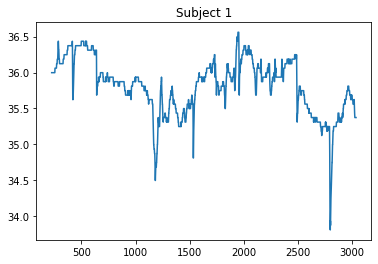

In [ ]:
import matplotlib.pyplot as plt
plt.plot(tsdat_i)
plt.title('Subject ' + str(select_subj))

Create differenced series and visualize it

* Ensure correct lag for the subject, obtained from average mutual information
* Drop nan values from differenced series

In [ ]:
# display correlation time (from AMI) that will be used for differencing
onoff_select_2 = onoff_select[['subject_id', 'tau_ami']]
print(onoff_select_2.to_string(index=False))

 subject_id  tau_ami
         29       14


Text(0.5, 1.0, 'Differenced Series for Subject 29')

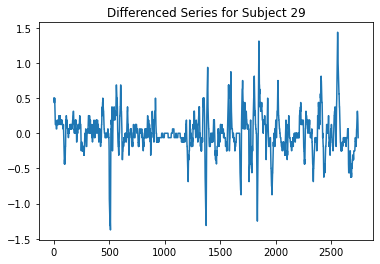

In [ ]:
#tsdat_i_diff = tsdat_i.diff(periods=21) #subj 1, 8
#tsdat_i_diff = tsdat_i.diff(periods=97) #subj 2
#tsdat_i_diff = tsdat_i.diff(periods=8) #subj 4
#tsdat_i_diff = tsdat_i.diff(periods=29) #subj 5
#tsdat_i_diff = tsdat_i.diff(periods=9) #subj 6
#tsdat_i_diff = tsdat_i.diff(periods=28) #subj 7
#tsdat_i_diff = tsdat_i.diff(periods=16) #subj 9
#tsdat_i_diff = tsdat_i.diff(periods=13) #subj 10
#tsdat_i_diff = tsdat_i.diff(periods=15) #subj 11
# read from onoffdat starting with subj 12

import numpy as np
tsdat_i_diff = tsdat_i.diff(periods=onoff_select['tau_ami']) #auto - from onoffdat
yd = tsdat_i_diff.to_numpy()
yd = yd[np.logical_not(np.isnan(yd))]
plt.plot(yd)
plt.title('Differenced Series for Subject ' + str(select_subj))

## Calculate multiscale entropies

In [ ]:
import EntropyHub as EH
#import numpy as np
#y = tsdat_i.to_numpy()
#s = np.std(y)
#sen = SampEn(y, m=2, r=0.15*s)
#sen
Mobj = EH.MSobject('SampEn', m = 2, r = 0.15)
msen = EH.MSEn(y, Mobj, Scales = 25, Methodx = 'coarse', RadNew = 1)
rmsen = EH.rMSEn(y, Mobj, Scales = 25, F_Order = 6, F_Num = 0.5, RadNew = 1)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Repeat calculations on the differenced series

In [ ]:
Mobj = EH.MSobject('SampEn', m = 2, r = 0.15)
msen_d = EH.MSEn(yd, Mobj, Scales = 25, Methodx = 'coarse', RadNew = 1)
rmsen_d = EH.rMSEn(yd, Mobj, Scales = 25, F_Order = 6, F_Num = 0.5, RadNew = 1)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Visualize multiscale entropies for the present subject

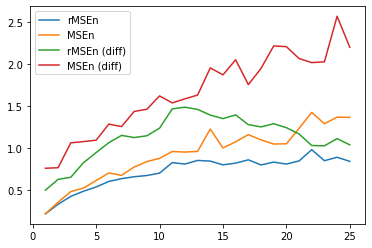

In [ ]:
import matplotlib.pyplot as plt
t = np.arange(1, 26, 1)
plt.plot(t, rmsen[0], label="rMSEn")
plt.plot(t, msen[0], label="MSEn")
plt.plot(t, rmsen_d[0], label="rMSEn (diff)")
plt.plot(t, msen_d[0], label="MSEn (diff)")
plt.legend()
plt.show()

## Store Results

### Current subject

Create dataframe with MSEn results for the present subject.

* First create subject label, ensuring correct subject id is specified
* Next create a dataframe

In [ ]:
id = np.repeat(select_subj, 25)
print(id[0:5])

[29 29 29 29 29]


In [ ]:
results = {'id': id, 'Scale': t, 'MSEn': msen[0], 'rMSEn': rmsen[0], 
           'MSEn_diff': msen_d[0], 'rMSEn_diff': rmsen_d[0]}
results_df = pd.DataFrame(results)
print(results_df.head())

   id  Scale      MSEn     rMSEn  MSEn_diff  rMSEn_diff
0  29      1  0.223005  0.221159   0.762575    0.502982
1  29      2  0.360511  0.335961   0.769187    0.630563
2  29      3  0.485822  0.429015   1.063731    0.655825
3  29      4  0.528022  0.489980   1.078776    0.827916
4  29      5  0.616953  0.540682   1.095535    0.948474


### All subjects

Add results to collection of previous results
* If this is the first subject being analyzed, uncomment the first line and
comment out the second one

In [ ]:
#results_all = results_df # only if this is the first subject being analyzed
results_all = pd.concat([results_all, results_df])
print(results_all)

    id  Scale      MSEn     rMSEn  MSEn_diff  rMSEn_diff
0   12      1  0.290258  0.255488   0.547672    0.495193
1   12      2  0.424600  0.393492   0.819392    0.677745
2   12      3  0.517310  0.493105   0.999491    0.836320
3   12      4  0.634973  0.569380   1.102264    1.026363
4   12      5  0.729589  0.618000   1.205210    1.218624
..  ..    ...       ...       ...        ...         ...
20  29     21  1.235188  0.849151   2.063693    1.168571
21  29     22  1.424613  0.982876   2.014903    1.032363
22  29     23  1.290984  0.851971   2.024382    1.028161
23  29     24  1.368276  0.892943   2.564949    1.113997
24  29     25  1.366092  0.844187   2.197225    1.040018

[400 rows x 6 columns]


## Visualize MSEn for all subjects

Plot refined rMSEn for original series (not differenced) of all available subjects

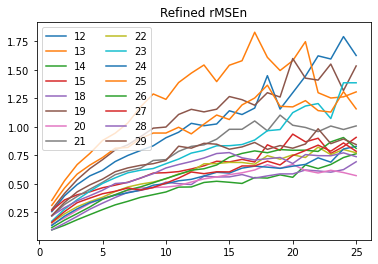

In [ ]:
import matplotlib.pyplot as plt
for i in results_all['id'].unique():
  results_ind = results_all['id'] == i
  results_i = results_all[results_ind]
  plt.plot(results_i['Scale'], results_i['rMSEn'], label=i)
plt.legend(ncol=2)
plt.title('Refined rMSEn')
plt.show()

Plot MSEn for original series (not differenced) of all available subjects

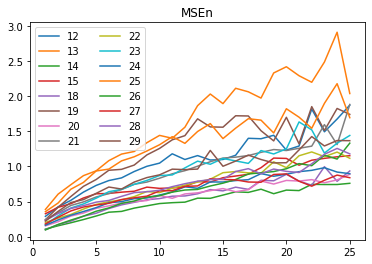

In [ ]:
import matplotlib.pyplot as plt
for i in results_all['id'].unique():
  results_ind = results_all['id'] == i
  results_i = results_all[results_ind]
  plt.plot(results_i['Scale'], results_i['MSEn'], label=i)
plt.legend(ncol=2)
plt.title('MSEn')
plt.show()

Plot refined rMSEn for differenced series of all available subjects

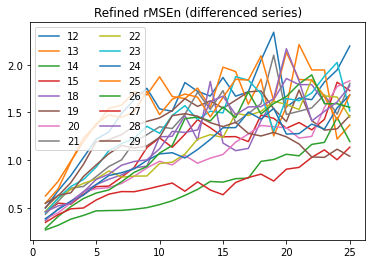

In [ ]:
import matplotlib.pyplot as plt
for i in results_all['id'].unique():
  results_ind = results_all['id'] == i
  results_i = results_all[results_ind]
  plt.plot(results_i['Scale'], results_i['rMSEn_diff'], label=i)
plt.legend(ncol=2)
plt.title('Refined rMSEn (differenced series)')
plt.show()

Plot MSEn for differenced series of all available subjects

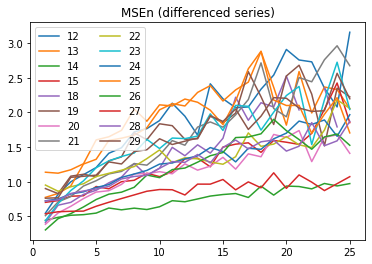

In [ ]:
import matplotlib.pyplot as plt
for i in results_all['id'].unique():
  results_ind = results_all['id'] == i
  results_i = results_all[results_ind]
  plt.plot(results_i['Scale'], results_i['MSEn_diff'], label=i)
plt.legend(ncol=2)
plt.title('MSEn (differenced series)')
plt.show()

## Save multiscale entropy results to Google Drive

Do this at the end of the analysis session

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
results_all.to_csv("/content/gdrive/My Drive/Work/Martel_MSEn/msen_results_2.csv")

## Collect all entropy results from different sessions

* Run only after all subjects have been analyzed

In [ ]:
# if not mounted, need to mount Google Drive prior to this
#from google.colab import drive
#drive.mount('/content/drive')

# read files
path = '/content/gdrive/MyDrive/Work/Martel_MSEn/msen_results.csv'
msen_dat1 = pd.read_csv(path)
path = '/content/gdrive/MyDrive/Work/Martel_MSEn/msen_results_2.csv'
msen_dat2 = pd.read_csv(path)

# combine data
msen_dat = pd.concat([msen_dat1, msen_dat2])
print(msen_dat.head())
print(msen_dat.shape)

   Unnamed: 0  id  Scale      MSEn     rMSEn  MSEn_diff  rMSEn_diff
0           0   1      1  0.263423  0.205158   0.447839    0.364125
1           1   1      2  0.387385  0.279742   0.541824    0.495795
2           2   1      3  0.444079  0.348884   0.791137    0.621024
3           3   1      4  0.486202  0.420711   0.783925    0.697576
4           4   1      5  0.538652  0.474578   0.979518    0.784498
(650, 7)


## Visualize multiscale entropy results for all subjects

### Nice example of spaghetti plots

https://www.python-graph-gallery.com/124-spaghetti-plot

https://www.python-graph-gallery.com/123-highlight-a-line-in-line-plot

In [ ]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14) })

# Change the style of plot
plt.style.use('seaborn-darkgrid')

# set figure size
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
# plot multiple lines
for column in df.drop('x', axis=1):
    plt.plot(df['x'], df[column], marker='', color='grey', linewidth=1, alpha=0.4)

# Now re do the interesting curve, but biger with distinct color
plt.plot(df['x'], df['y5'], marker='', color='orange', linewidth=4, alpha=0.7)
 
# Change x axis limit
plt.xlim(0,12)
 
# Let's annotate the plot
num=0
for i in df.values[9][1:]:
    num+=1
    name=list(df)[num]
    if name != 'y5':
        plt.text(10.2, i, name, horizontalalignment='left', size='small', color='grey')

# And add a special annotation for the group we are interested in
plt.text(10.2, df.y5.tail(1), 'Mr Orange', horizontalalignment='left', size='small', color='orange')
 
# Add titles
plt.title("Evolution of Mr Orange vs other students", loc='left', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Score")

# Show the graph
plt.show()

### Continue with plotting

Create a list of subjects that had pressure injuries

In [ ]:
prinj_id_list = onoffdat[onoffdat['prinj'] == 1]['subject_id'].unique()
print(prinj_id_list)

[ 1  4 14 15 18 20 23 25 27 28 29]


Red curves depict subjects with pressure injuries

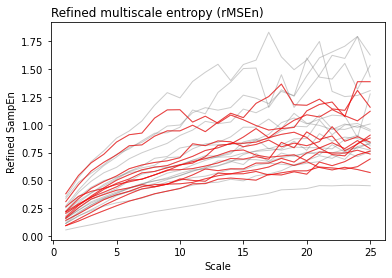

In [ ]:
import matplotlib.pyplot as plt
for i in msen_dat['id'].unique():
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['rMSEn'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['rMSEn'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
plt.title('Refined multiscale entropy (rMSEn)', loc='left')
plt.xlabel("Scale")
plt.ylabel("Refined SampEn")
plt.show()

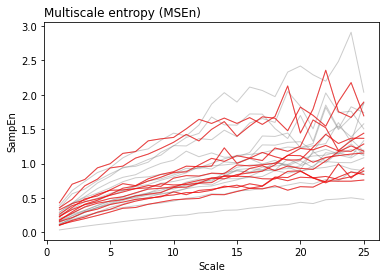

In [ ]:
import matplotlib.pyplot as plt
for i in msen_dat['id'].unique():
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['MSEn'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['MSEn'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
plt.title('Multiscale entropy (MSEn)', loc='left')
plt.xlabel("Scale")
plt.ylabel("SampEn")
plt.show()

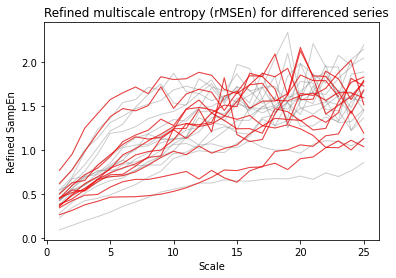

In [ ]:
import matplotlib.pyplot as plt
for i in msen_dat['id'].unique():
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['rMSEn_diff'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['rMSEn_diff'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
plt.title('Refined multiscale entropy (rMSEn) for differenced series', 
          loc='left')
plt.xlabel("Scale")
plt.ylabel("Refined SampEn")
plt.show()

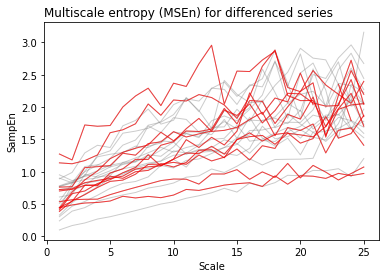

In [ ]:
import matplotlib.pyplot as plt
for i in msen_dat['id'].unique():
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['MSEn_diff'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msen_dat['id'] == i
  msen_i = msen_dat[ind_i]
  plt.plot(msen_i['Scale'], msen_i['MSEn_diff'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
plt.title('Multiscale entropy (MSEn) for differenced series', 
          loc='left')
plt.xlabel("Scale")
plt.ylabel("SampEn")
plt.show()

## Save combined MSEn results for all subjects

In [ ]:
results_all.to_csv("/content/gdrive/My Drive/Work/Martel_MSEn/msen_results_all.csv")

# Looped calculations of many base entropies

In [ ]:
other_entropies = pd.DataFrame()
other_entropies['id'] = onoffdat['subject_id'].unique()
print(other_entropies.head())
#print(other_entropies.loc[:, ['id']])

   id
0   1
1   2
2   4
3   5
4   6


In [ ]:
#AttnEn = [] #good performance (rank 2) in expected direction
BubbEn = [] #good performance (rank 3/4) in opposite direction
#CoSiEn = [] #good performance (rank 3/4) in expected direction
#CondEn1 = []
#CondEn2 = []
#DispEn1 = [] #ok performance (rnak 7) in opposite direction
#DispEn2 = [] #good performance (rank 5) in expected direction
#DistEn = []
#EnofEn1 = []
#EnofEn2 = []
#EnofEn3 = []
#FuzzEn = []
#GridEn = []
#K2En = [] #ok performance (rank 8) in expected direction
#PermEn = [] #ok performance (rank 6) in opposite direction
#PhasEn = [] #good performance (rank 1) in opposite direction
#SampEn = []
#SlopEn = []
# SpecEn1 = []
# SpecEn2 = []
# SyDyEn3 = []
# SyDyEn6 = []

Try out a single run of the selected entropy

In [ ]:
try_en = EH.SyDyEn(y)
try_en[0]

2.851199420684597

IncrEn was left out due to warnings about division by 0

In [ ]:
import EntropyHub as EH
for i in other_entropies['id'].tolist():
  #select_subj = other_entropies.loc[0, ['id']]
  #subj_i = tsdat['subject_id'] == select_subj[0]
  subj_i = tsdat['subject_id'] == i
  tsdat_i = tsdat[subj_i]
  tsdat_i = tsdat_i.filter(items=['temperature'])
  # get section when ibutton was measuring body temp
  j = (onoffdat['subject_id']== i) & (onoffdat['series'] == 'y')
  onoff_select = onoffdat[j]
  j_on = onoff_select['i_on'].tolist()
  j_off = onoff_select['i_off'].tolist()
  tsdat_i = tsdat_i[(j_on[0] -1): j_off[0]]
  # create numpy array
  y = tsdat_i.to_numpy()
  # calculate other entropies
  #AttnEn.append(EH.AttnEn(y)[0])
  #BubbEn.append(EH.BubbEn(y)[0][0])
  #CoSiEn.append(EH.CoSiEn(y)[0])
  #CondEn1.append(EH.CondEn(y)[0][0])
  #CondEn2.append(EH.CondEn(y)[0][1])
  #DispEn1.append(EH.DispEn(y, c=6)[0])
  #DispEn2.append(EH.DispEn(y, c=6)[1])
  #DistEn.append(EH.DistEn(y)[0])
  #EnofEn1.append(EH.EnofEn(y)[0])
  #EnofEn2.append(EH.EnofEn(y)[1])
  #EnofEn3.append(EH.EnofEn(y)[2])
  #FuzzEn.append(EH.FuzzEn(y)[0][1])
  #GridEn.append(EH.GridEn(y)[0])
  #K2En.append(EH.K2En(y)[0][1])
  #PermEn.append(EH.PermEn(y)[0][1])
  #PhasEn.append(EH.PhasEn(y))
  #SampEn.append(EH.SampEn(y)[0][2])
  #SlopEn.append(EH.SlopEn(y)[0])
  specen_i = EH.SpecEn(y, Freqs=(0, 6/1440))
  SpecEn1.append(specen_i[0])
  SpecEn2.append(specen_i[1])
  SyDyEn3.append(EH.SyDyEn(y)[0])
  SyDyEn6.append(EH.SyDyEn(y, c=6)[0])

#other_entropies['AttnEn'] = AttnEn
#other_entropies['BubbEn'] = BubbEn
#other_entropies['CoSiEn'] = CoSiEn
#other_entropies['CondEn1'] = CondEn1
#other_entropies['CondEn2'] = CondEn2
#other_entropies['DispEn1'] = DispEn1
#other_entropies['DispEn2'] = DispEn2
#other_entropies['DistEn'] = DistEn
#other_entropies['EnofEn1'] = EnofEn1
#other_entropies['EnofEn2'] = EnofEn2
#other_entropies['EnofEn3'] = EnofEn3
#other_entropies['FuzzEn'] = FuzzEn
#other_entropies['GridEn'] = GridEn
#other_entropies['K2En'] = K2En
#other_entropies['PermEn'] = PermEn
#other_entropies['PhasEn'] = PhasEn
#other_entropies['SampEn'] = SampEn
#ther_entropies['SlopEn'] = SlopEn
other_entropies['SpecEn1'] = SpecEn1
other_entropies['SpecEn2'] = SpecEn2
other_entropies['SyDyEn3'] = SyDyEn3
other_entropies['SyDyEn6'] = SyDyEn6
print(other_entropies.head())

   id   SpecEn1   SpecEn2   SyDyEn3   SyDyEn6
0   1  0.117472  0.337197  2.954370  2.888329
1   2  0.117126  0.337398  3.188797  2.626912
2   4  0.117229  0.337481  2.640174  2.628127
3   5  0.117860  0.338857  2.995318  2.699214
4   6  0.118270  0.344205  2.629422  3.167371


In [ ]:
other_entropies.dtypes

id           int64
SpecEn1    float64
SpecEn2    float64
SyDyEn3    float64
SyDyEn6    float64
dtype: object

In [ ]:
print(other_entropies)

    id   SpecEn1   SpecEn2   SyDyEn3   SyDyEn6
0    1  0.117472  0.337197  2.954370  2.888329
1    2  0.117126  0.337398  3.188797  2.626912
2    4  0.117229  0.337481  2.640174  2.628127
3    5  0.117860  0.338857  2.995318  2.699214
4    6  0.118270  0.344205  2.629422  3.167371
5    7  0.117022  0.337678  2.972938  2.463471
6    8  0.116608  0.336601  2.893426  2.452393
7    9  0.116840  0.336406  2.767255  2.638503
8   10  0.117493  0.337788  3.619096  3.097156
9   11  0.117920  0.338337  2.679791  2.616181
10  12  0.121010  0.360671  2.670283  2.320721
11  13  0.117613  0.337382  2.653824  2.564973
12  14  0.119751  0.358695  2.950572  2.965974
13  15  0.116868  0.337168  2.684635  2.834084
14  18  0.127119  0.426443  2.871577  2.631843
15  19  0.119181  0.343653  2.796506  3.306111
16  20  0.119475  0.347434  2.791204  2.390855
17  21  0.117394  0.342513  2.709675  2.307041
18  22  0.119436  0.357662  3.068375  2.434139
19  23  0.118362  0.356742  2.766329  2.367218
20  24  0.118

### Save AttnEn to file

Mount drive, once only

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Save file

In [ ]:
other_entropies.to_csv("/content/gdrive/My Drive/Work/Martel_MSEn/Spec_SyDyEn.csv")

# Looped calculations of many multiscale entropies

Change data type of subject_id

In [ ]:
onoffdat.subject_id.astype('int64').dtypes

dtype('int64')

Make grid of all id and scale combinations, following an
[example at stackoverflow](https://stackoverflow.com/questions/43800390/how-to-create-all-combinations-column-wise-for-multiple-variables-in-pandas)


In [ ]:
import itertools

id = list(onoffdat['subject_id'].unique())
cgscale = list(range(1, 31)) # scale 1 to 30 (typical use)
#cgscale = list(range(1, 32)) # scale 1 to 31 (for hierarchical hMSEn)

a = [id, cgscale]

#print(list(itertools.product(*a)))

#idx = ['c{}'.format(i) for i in range(1, len(data)+1)] #if named index is desired
grid_dat = list(itertools.product(*a))
msendf = pd.DataFrame(grid_dat, columns=['id', 'cgscale'])

print(msendf)

     id  cgscale
0     1        1
1     1        2
2     1        3
3     1        4
4     1        5
..   ..      ...
775  29       26
776  29       27
777  29       28
778  29       29
779  29       30

[780 rows x 2 columns]


### Trial: calculate selected entropy for a single subject 

And try adding to dataframe to track results.

_Select subject and define series (y) from the subjectwise computations in an earlier section before running this cell._

__Notes__

* Composite cMSEn is quite limited when the refined=true option is desired. SampEn is the only base entropy for which that option is available.
* For BubbEn, cMSEn gives a monotonically increasing function (at least for subject 1) while rMSEn gives a more interesting function that decreases at first and then rises to another maximum near scale 20 before decreasing again at higher scales.

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

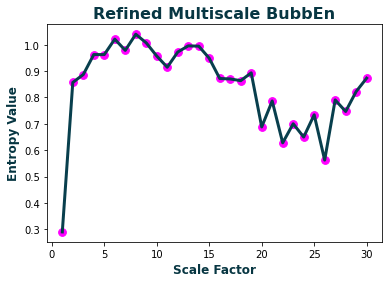

(array([0.29028703, 0.85676601, 0.88679714, 0.96245462, 0.96242326,
       1.02082589, 0.97849589, 1.03947961, 1.00672939, 0.95690902,
       0.91451129, 0.97197996, 0.99549402, 0.99431265, 0.94859035,
       0.87176135, 0.87008852, 0.8635146 , 0.89317734, 0.68816655,
       0.78649317, 0.62800775, 0.70015471, 0.64989517, 0.73407395,
       0.56257819, 0.79051571, 0.74679535, 0.82246333, 0.8730519 ]), 25.266793695120104)


In [ ]:
import EntropyHub as EH

Mobj = EH.MSobject(EnType='BubbEn', m=4)
#Mobj = EH.MSobject(EnType='PhasEn', K=24)
#Mobj = EH.MSobject(EnType='FuzzEn', m=2)
#Mobj = EH.MSobject(EnType='DispEn', c=6)
# BubbEn does not need r parameter
#rmsen = EH.rMSEn(y, Mobj, Scales = 30, F_Order = 6, F_Num = 0.5, RadNew = 1, Plotx=True) # for SampEn
rmsen = EH.rMSEn(y, Mobj, Scales=30, F_Order = 6, F_Num = 0.5, Plotx=True) # for BubbEn, PhasEn, K2En, CondEn, FuzzEn
#msen = EH.MSEn(y, Mobj, Scales=30, Plotx=True)
print(rmsen)

In [ ]:
import EntropyHub as EH
help(EH.MSobject)

Help on function MSobject in module EntropyHub._MSobject:

MSobject(EnType='SampEn', **kwargs)
    MSobject  creates an object to store multiscale entropy parameters.
    
    .. code-block:: python
    
        [Mobj] = MSobject() 
        
    Returns a multiscale entropy object (``Mobj``) based on that originally
    proposed by Costa et al. using the following default  parameters:
    EnType = 'SampEn', embedding dimension = 2, time delay = 1, 
    radius = 0.2*SD(``Sig``), logarithm = natural
     
    .. code-block:: python
    
        [Mobj] = MSobject(EnType)
        
    Returns a multiscale entropy object using the specified entropy method
    (``EnType``) and the default parameters for that entropy method.
    To see the default parameters for a particular entropy method,          
    type:   `help(EnType)`   (e.g.  ``help(SampEn)``)
    
    .. code-block:: python
    
        [Mobj] = MSobject(EnType, keyword = value, ...)
        
    Returns a multiscale entropy object

In [ ]:
print(list(rmsen_attn[0]))

NameError: ignored

Only first 2048 samples were used in hierarchical decomposition.             
The last 712 samples of the data sequence were ignored.
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



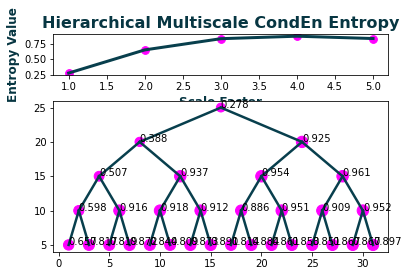

(array([0.27819767, 0.38832737, 0.92468072, 0.50724939, 0.93741954,
        0.95355183, 0.96050437, 0.59834023, 0.91555532, 0.91830924,
        0.91229133, 0.88591351, 0.95077065, 0.90921445, 0.95234341,
        0.65654975, 0.81724349, 0.81852097, 0.87228586, 0.84363895,
        0.80864254, 0.87294516, 0.89116528, 0.81402787, 0.88420137,
        0.8614862 , 0.85312879, 0.85073411, 0.86738968, 0.86702713,
        0.89672695]),
 array([0.27819767, 0.65650404, 0.83968128, 0.88034227, 0.84223213]),
 25.46838312252394)

In [ ]:
Mobj = EH.MSobject('CondEn', m = 2, tau = 2, c = 12, Logx = 2, Norm = True)
EH.hMSEn(y, Mobj, Scales = 5, Plotx = True)

 . . . . . . . . . . . . . . . .

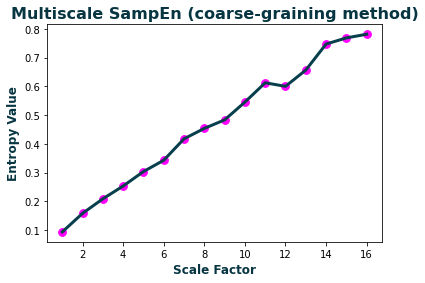

(array([0.09360532, 0.15819191, 0.20878039, 0.25328674, 0.30351091,
        0.34288493, 0.4174586 , 0.45369677, 0.4833114 , 0.54512022,
        0.61233902, 0.59998194, 0.6564832 , 0.74702641, 0.76849662,
        0.78119451]), 7.425368888520729)

In [ ]:
import EntropyHub as EH
Mobj = EH.MSobject('SampEn', m=2, r=0.2)
EH.MSEn(y[0:2048], Mobj, Scales=16, RadNew=1, Plotx=True)

 . . . . . . . . . . . . . . . .

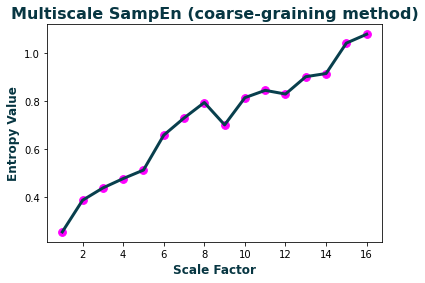

(array([0.25310407, 0.38542722, 0.43684245, 0.47596891, 0.5114988 ,
        0.65733773, 0.72903824, 0.7938005 , 0.70043319, 0.81406011,
        0.84460896, 0.82912124, 0.90165907, 0.91498269, 1.04206012,
        1.07904219]), 11.368985490645807)

In [ ]:
import EntropyHub as EH
Mobj = EH.MSobject('SampEn', m=2, r=0.2)
EH.MSEn(y[0:2048], Mobj, Scales=16, RadNew=3, Plotx=True)

 . . . . . . . . . . . . . . . .

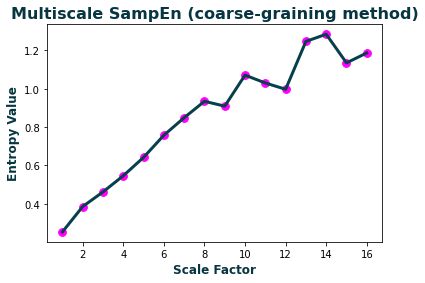

(array([0.25310407, 0.38542722, 0.46164204, 0.54604126, 0.64172598,
        0.75711883, 0.84857484, 0.9340719 , 0.90891062, 1.07062338,
        1.02961942, 0.99682959, 1.24634583, 1.28375472, 1.13442174,
        1.18616818]), 13.684379645051443)

In [ ]:
import EntropyHub as EH
Mobj = EH.MSobject('SampEn', m=2, r=0.2)
EH.MSEn(y[0:2048], Mobj, Scales=16, RadNew=4, Plotx=True)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

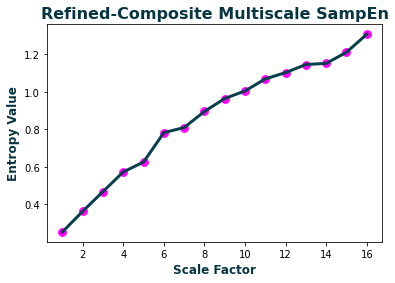

(array([0.25310407, 0.3631035 , 0.4683025 , 0.57327635, 0.62609242,
        0.78283486, 0.81008683, 0.89585702, 0.96497152, 1.00537533,
        1.06969404, 1.10337487, 1.14638544, 1.15251134, 1.21177286,
        1.30788431]), 13.734627250525042)

In [ ]:
import EntropyHub as EH
Mobj = EH.MSobject('SampEn', m=2, r=0.2)
EH.cMSEn(y[0:2048], Mobj, Scales=16, RadNew=4, Refined=True, Plotx=True)

In [ ]:
import EntropyHub as EH
Mobj = EH.MSobject('SampEn', m = 2, r=0.2)
#EH.hMSEn(y, Mobj, Scales = 5, RadNew=1, Plotx = True)
try_hmsen = EH.hMSEn(y, Mobj, Scales=5, RadNew=1, Plotx = False)
print(list(try_hmsen[0]))
print(list(try_hmsen[1]))
trylist = []
trylist.append(try_hmsen[2])
print(trylist)

Only first 2048 samples were used in hierarchical decomposition.             
The last 766 samples of the data sequence were ignored.
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

[0.09360531696828846, 0.15819191279506153, 0.2545270043297386, 0.25328674496092274, 0.5743445104269821, 0.4051096911487412, 0.4294590373312629, 0.4536967690516853, 0.8312354823770743, 1.1132921793459316, 0.9690227404247372, 0.7739992771890402, 0.6536028446140995, 0.7524797197904771, 0.7454170450940103, 0.7811945050160957, 1.6035381903069121, 1.3046614066230193, 1.1343639796319525, 1.8437192081587659, 2.4720032449520923, 1.3363671871633833, 1.9187591599893623, 1.4107672176386163, 1.2949703089823144, 1.1246589976062105, 1.2589549387432892, 1.350345126996961, 1.213022639845854, 1.218611675074056, 1.2727396615730282]
[0.09360531696828846, 0.20635945856240007, 0.4155499959669773, 0.7865932572358819, 1.4086673405188694]
[30.999947724149965]


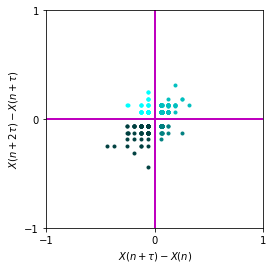

0.8903232348637357

In [ ]:
EH.PhasEn(y, tau=1, K=4, Plotx=True)

Extend the list by adding computed values of multiscale entropy.
* `extend` allows adding multiple elements to the list, unlike `append`

In [ ]:
rMSEn = []
rMSEn.extend(list(rmsen[0]))
print(rMSEn)

[0.20515843689574095, 0.2797418443335595, 0.3488839131675458, 0.42071062128024583, 0.47457809250139205, 0.513841307595491, 0.5684081900648084, 0.58140314212033, 0.6139197433000325, 0.6405342290916715, 0.6556565716444466, 0.713807039828819, 0.815080829942642, 0.8264782326048136, 0.8898574748059995, 0.966052241433219, 0.8836390687640118, 0.913935018181696, 0.9331414222260108, 0.8865185735404849, 0.790139446547255, 0.7326259915337328, 0.720926744667021, 0.832072652790138, 0.8815477834302822, 0.8950133334268701, 0.9870598027623624, 0.9231636111619171, 1.000631880307906, 0.8919980393051105]


Add results to existing dataframe.
* Pandas `concat` is used here since the new column length does not match length of existing columns

In [ ]:
msendf_add = pd.DataFrame(rMSEn, columns=['rMSEn'])
msendf = pd.concat([msendf, msendf_add], axis=1)
print(msendf)

     id  cgscale     rMSEn
0     1        1  0.205158
1     1        2  0.279742
2     1        3  0.348884
3     1        4  0.420711
4     1        5  0.474578
..   ..      ...       ...
775  29       26       NaN
776  29       27       NaN
777  29       28       NaN
778  29       29       NaN
779  29       30       NaN

[780 rows x 3 columns]


### Looped calculation over all subjects

Drop column from trial over single subject

In [ ]:
msendf.head()

,id,cgscale
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


Optional: drop existing MSEn column

In [ ]:
# run only if it is not important to retain the last calculation
msendf = msendf.drop(['rMSEn'], axis=1) # adapt colname
print(msendf)

     id  cgscale
0     1        1
1     1        2
2     1        3
3     1        4
4     1        5
..   ..      ...
775  29       26
776  29       27
777  29       28
778  29       29
779  29       30

[780 rows x 2 columns]


Create MS entropy object for looped run  
and  
Create empty list(s) for storing results

In [ ]:
import EntropyHub as EH

#Mobj = EH.MSobject('SampEn', m = 2, r = 0.15)
#Mobj = EH.MSobject('AttnEn')
# BubbEn: entropy at each scale + conditional Renyi entropy (single value)
Mobj = EH.MSobject(EnType='BubbEn', m = 11) # BubbEn needs only m and tau, no r
#Mobj = EH.MSobject(EnType='PhasEn', K=4) # PhasEn
#Mobj = EH.MSobject(EnType='K2En', m=3)
#Mobj = EH.MSobject(EnType='CondEn', m=3, c=12)
#Mobj = EH.MSobject(EnType='PermEn', m=3)
#Mobj = EH.MSobject(EnType='FuzzEn', m=3)
#Mobj = EH.MSobject(EnType='DispEn', m=3, c=12)

# ensure correct name to avoid overwriting existing results
msen1 = []
#msen2 = []
#msen3 = []

Trial: itertools repeat() to add elements to list

In [ ]:
list(itertools.repeat(-1,10))

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]



---


__The Loop__



---



* rMSEn ran in 39 s (56 s for m=3 and 70 s for m=4)
* cMSEn ran in 4 min 5 s for m=2; 4 min 56 s for m=3
* AttnEn 2 s
* rMSEn for BubbEn ran in 6 sec for m=3 and less than that for m=2
* PhasEn ran in 1 sec for K=24
* CoSiEn was skipped due to many errors in arccos evaluation
* K2En ran in 38 and 50 sec for m= 2, 3
* CondEn ran in 2 sec for m=3, c=12
* PermEn ran in 8 sec for m=3
* FuzzEn ran in 34 sec for m=2 and 54 sec for m=3
* DispEn ran in 14 sec for m=2 and 28 sec for m=3 (c=6); 72 sec for c=12, m=3

In [ ]:
import EntropyHub as EH
for i in list(onoffdat['subject_id'].unique()):
  subj_i = tsdat['subject_id'] == i
  tsdat_i = tsdat[subj_i]
  tsdat_i = tsdat_i.filter(items=['temperature'])
  # get section when ibutton was measuring body temp
  j = (onoffdat['subject_id']== i) & (onoffdat['series'] == 'y')
  onoff_select = onoffdat[j]
  j_on = onoff_select['i_on'].tolist()
  j_off = onoff_select['i_off'].tolist()
  tsdat_i = tsdat_i[(j_on[0] -1): j_off[0]]
  # create numpy array
  y = tsdat_i.to_numpy()
  # calculate MS entropy
  #msen_i = EH.rMSEn(y, Mobj, Scales = 30, F_Order = 6, F_Num = 0.5, RadNew = 1)
  #msen_i = EH.MSEn(y, Mobj, Scales = 30, Methodx='coarse')
  #msen_i = EH.cMSEn(y, Mobj, Scales = 30, Refined=True, RadNew=4)
  #hmsen_i = EH.hMSEn(y, Mobj, Scales = 5, RadNew=1, Plotx = False)
  msen_i = EH.rMSEn(y, Mobj, Scales=30, F_Order = 6, F_Num = 0.5, Plotx=False) # BubbEn, PhasEn, K2En, CondEn, PermEn, DispEn
  #msen_i = EH.MSEn(y, Mobj, Scales=30, Plotx=False) # for CoSiEn
  # store values
  msen1.extend(list(msen_i[0]))
  #msen2.append(msen_i[1])
  #msen2.extend(list(itertools.repeat(-1, 29)))
  #msen3.append(hmsen_i[2])
  #msen3.extend(list(itertools.repeat(-1, 30)))

print('')
print('Done with MS entropy calculations for all subjects')
print(len(msen1))

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Add MS entropies to dataframe

In [ ]:
# create additional df
d = {'rmsbubben_m11': msen1}
msendf_add = pd.DataFrame(data=d)
# concat with existing df
msendf = pd.concat([msendf, msendf_add], axis=1)

print(msendf)

     id  cgscale  rmsbubben_m4  rmsbubben_m5  rmsbubben_m6  rmsbubben_m7  \
0     1        1      0.290287      1.121513      1.179566      0.755234   
1     1        2      0.856766      0.970317      0.980663      0.981597   
2     1        3      0.886797      1.022599      0.946981      0.978128   
3     1        4      0.962455      1.065049      0.953919      1.043912   
4     1        5      0.962423      1.087362      0.993600      0.965440   
..   ..      ...           ...           ...           ...           ...   
775  29       26      0.958046      0.683453      0.962882      0.698484   
776  29       27      0.959528      0.825892      0.674975      0.587290   
777  29       28      0.886527      0.825683      0.681491      0.417790   
778  29       29      0.867302      0.827225      0.655476      0.563992   
779  29       30      0.789428      0.843601      0.759622      0.514680   

     rmsbubben_m8  rmsbubben_m9  rmsbubben_m10  rmsbubben_m11  
0        0.260681      

### Save MS entropies to file



In [ ]:
#Mount drive, once only
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Save file

msendf.to_csv("/content/gdrive/My Drive/Work/Martel_MSEn/rmsbubben_v2.csv", 
              index=False)

### Visualize MS entropy

In [ ]:
# Create list of subjects with pressure injuries - ONCE only
prinj_id_list = onoffdat[onoffdat['prinj'] == 1]['subject_id'].unique()
print(prinj_id_list)

[ 1  4 14 15 18 20 23 25 27 28 29]


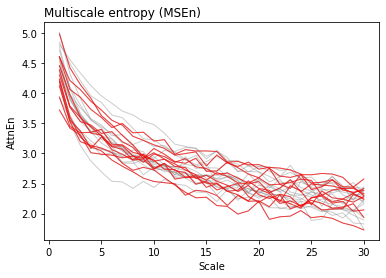

In [ ]:
import matplotlib.pyplot as plt
for i in msendf['id'].unique():
  ind_i = msendf['id'] == i
  msen_i = msendf[ind_i]
  plt.plot(msen_i['cgscale'], msen_i['rMSEn'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msendf['id'] == i
  msen_i = msendf[ind_i]
  plt.plot(msen_i['cgscale'], msen_i['rMSEn'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
#plt.title('Refined multiscale entropy (rMSEn)', loc='left')
plt.title('Multiscale entropy (MSEn)', loc='left')
plt.xlabel("Scale")
#plt.ylabel("SampEn")
plt.ylabel("AttnEn")
#plt.xlim(0,5)
plt.show()

Bubble Entropy

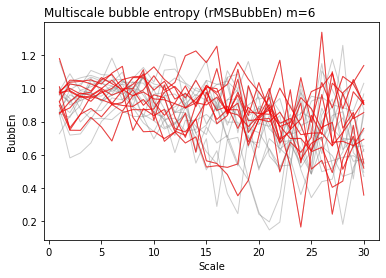

In [ ]:
import matplotlib.pyplot as plt
for i in msendf['id'].unique():
  ind_i = msendf['id'] == i
  msen_i = msendf[ind_i]
  plt.plot(msen_i['cgscale'], msen_i['rmsbubben_m6'], color='grey', 
           linewidth=1, alpha=0.4)

for i in prinj_id_list:
  ind_i = msendf['id'] == i
  msen_i = msendf[ind_i]
  plt.plot(msen_i['cgscale'], msen_i['rmsbubben_m6'], color='red', 
           linewidth=1, alpha=0.7)

#plt.legend(loc=0, ncol=2)
#plt.title('Refined multiscale entropy (rMSEn)', loc='left')
plt.title('Multiscale bubble entropy (rMSBubbEn) m=6', loc='left')
plt.xlabel("Scale")
#plt.ylabel("SampEn")
plt.ylabel("BubbEn")
#plt.xlim(0,5)
plt.show()